In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Flatten,Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pandas as pd
import itertools
import shutil
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
import os
import cv2

In [ ]:
Train="/content/drive/MyDrive/Old"
Evaluation="/content/drive/MyDrive/OldTest"

In [ ]:
import keras
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath,cv2.IMREAD_COLOR), (224, 224))
            image = cv2.cvtColor(image , cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

uniq_labels = sorted(os.listdir(Train))
image, labels = load_images(directory = Train)
if uniq_labels == sorted(os.listdir(Evaluation)):
 X_test, y_test = load_images(directory = Evaluation)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(image,labels, test_size =0.2, stratify = labels)

In [ ]:
print("The size of training dataset is: ", X_train.shape)
print("The size of validation dataset is: ", X_eval.shape)
print("The size of testing dataset is: ", X_test.shape)
print("The size of training dataset y is: ", y_train.shape)
print("The size of evalation dataset y is: ", y_eval.shape)
print("The size of testing dataset y is: ", y_test.shape)

The size of training dataset is:  (692, 224, 224, 3)
The size of validation dataset is:  (173, 224, 224, 3)
The size of testing dataset is:  (865, 224, 224, 3)
The size of training dataset y is:  (692,)
The size of evalation dataset y is:  (173,)
The size of testing dataset y is:  (865,)


In [ ]:
X_train = X_train.astype('float32')/255.0
X_eval= X_eval.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_eval = to_categorical(y_eval)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.2, 
    zoom_range=0.10, 
     shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest")

In [ ]:
Train_data=train_datagen.flow(X_train,y_train,batch_size=21,shuffle=True)
Evalu_data=train_datagen.flow(X_eval,y_eval,batch_size=21,shuffle=True)
Test_data=train_datagen.flow(X_test,y_test,batch_size=21,shuffle=True)

In [ ]:
Model_vgg16 = VGG16(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_mNetV2 = MobileNetV2(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_resnet = ResNet50(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_InceptionV3=InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet',classes=3)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in Model_vgg16.layers:
    layer.trainable = False
for layer in Model_mNetV2.layers:
    layer.trainable = False
for layer in Model_resnet.layers:
    layer.trainable = False
for layer in Model_InceptionV3.layers:
    layer.trainable = False
# un-freeze the BatchNorm layers
for layer in Model_mNetV2.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
for layer in Model_resnet.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
for layer in Model_InceptionV3.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
model2 = Model_mNetV2.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.6)(model2)
model2  = Dense(3, activation='softmax')(model2)
model2_mNetV2= Model(inputs = Model_mNetV2.input , outputs = model2)
model2_mNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.01)

In [ ]:
history21 = model2_mNetV2.fit(Train_data,epochs=10,batch_size= 2,validation_data=Evalu_data,callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True),

                        learning_rate_reduction
                    ])

Epoch 1/10
33/33 [==============================] - 119s 3s/step - loss: 0.8372 - accuracy: 0.6445 - val_loss: 0.8819 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - 116s 4s/step - loss: 0.3073 - accuracy: 0.8801 - val_loss: 0.8041 - val_accuracy: 0.6821 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - 120s 4s/step - loss: 0.1306 - accuracy: 0.9581 - val_loss: 0.6603 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - 121s 4s/step - loss: 0.1437 - accuracy: 0.9523 - val_loss: 0.5876 - val_accuracy: 0.7746 - lr: 0.0010
Epoch 5/10
33/33 [==============================] - 121s 4s/step - loss: 0.0733 - accuracy: 0.9827 - val_loss: 0.5028 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 6/10
33/33 [==============================] - 119s 4s/step - loss: 0.0638 - accuracy: 0.9841 - val_loss: 0.5610 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 7/10
33/33 [==============================] - 121s 4s/step - loss: 0.0

In [ ]:
model2_mNetV2.save('/content/drive/MyDrive/Old/modelNetV2_3c.h5')

NameError: ignored

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Old/modelNetV2_3c.h5')

OSError: ignored

In [ ]:
score = model2_mNetV2.evaluate(x= X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2_mNetV2.evaluate(Evalu_data, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 86.358 %
Accuracy for evaluation images: 78.035 %


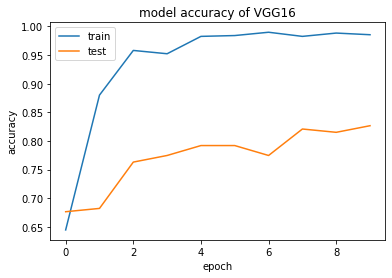

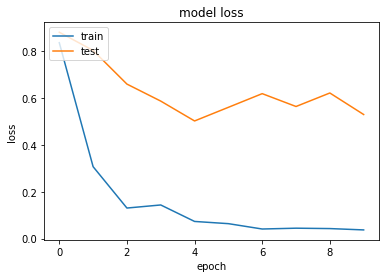

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history21.history['accuracy'])
plt.plot(history21.history['val_accuracy'])
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history21.history['loss'])
plt.plot(history21.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (10, 10))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

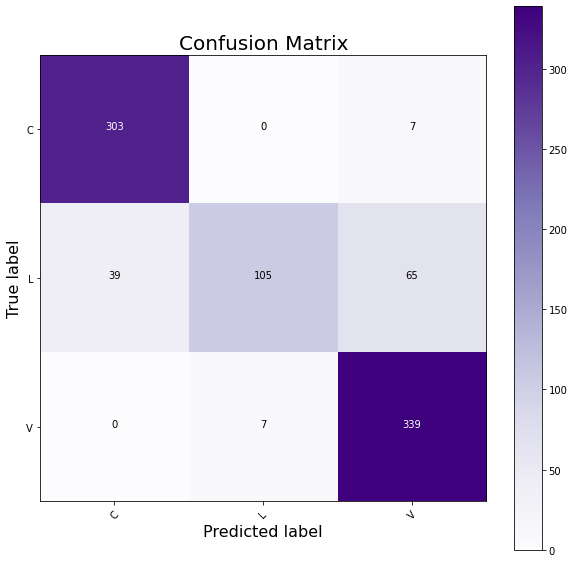

In [ ]:
y_test_pred = model2_mNetV2.predict(X_test, batch_size = 2, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
model4 = Model_InceptionV3.output#head mode
model4 = Flatten()(model4)
model4 = Dense(units=1024, activation='relu')(model4)
model4 = Dropout(0.6)(model4)
model4 = Dense(units=3, activation='softmax')(model4)
model4_InceptionV3= Model(inputs = Model_InceptionV3.input , outputs = model4)
model4_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history4 = model4_InceptionV3.fit(Train_data,epochs=5,batch_size= 2,validation_data=Evalu_data,callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True),

                        learning_rate_reduction
                    ])

Epoch 1/5
33/33 [==============================] - 266s 8s/step - loss: 14.8630 - accuracy: 0.6040 - val_loss: 2.6510 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 2/5
33/33 [==============================] - 260s 8s/step - loss: 1.7238 - accuracy: 0.8671 - val_loss: 0.1978 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 3/5
33/33 [==============================] - 253s 8s/step - loss: 0.3915 - accuracy: 0.9379 - val_loss: 0.5811 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 4/5
33/33 [==============================] - 258s 8s/step - loss: 0.1947 - accuracy: 0.9639 - val_loss: 0.2213 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 5/5
33/33 [==============================] - 261s 8s/step - loss: 0.2977 - accuracy: 0.9538 - val_loss: 0.5036 - val_accuracy: 0.8613 - lr: 0.0010


In [ ]:
model4_InceptionV3.save('/content/drive/MyDrive/Old/InceptionV3_3c.h5')

In [ ]:
score = model4_InceptionV3.evaluate(x= X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model4_InceptionV3.evaluate(Evalu_data, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 92.139 %
Accuracy for evaluation images: 87.283 %


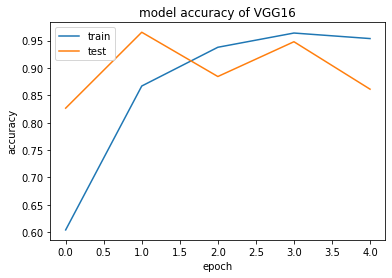

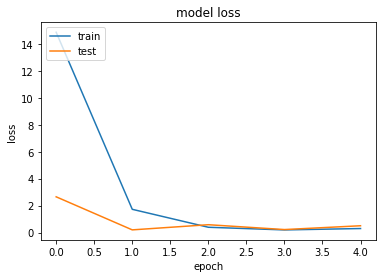

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

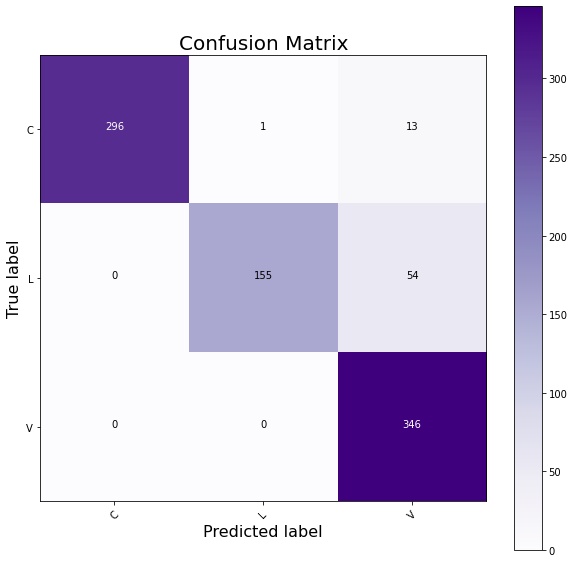

In [ ]:
y_test_pred =model4_InceptionV3.predict(X_test, batch_size = 2, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
#Model_vgg16 = VGG16(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_mNetV2 = MobileNetV2(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_resnet = ResNet50(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_InceptionV3=InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet',classes=3)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
for layer in Model_mNetV2.layers:
    layer.trainable = False
for layer in Model_resnet.layers:
    layer.trainable = False
for layer in Model_InceptionV3.layers:
    layer.trainable = False

In [ ]:
model2 = Model_mNetV2.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.6)(model2)
model2  = Dense(3, activation='softmax')(model2)
model2_mNetV2= Model(inputs = Model_mNetV2.input , outputs = model2)
model2_mNetV2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

NameError: ignored

In [ ]:
history09= model2_mNetV2.fit(X_train1,y_train1,validation_data=(x_new,y_new),
                    epochs=15,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True),

                        learning_rate_reduction
                    ])

Epoch 1/15
34/34 [==============================] - 6s 138ms/step - loss: 0.1358 - accuracy: 0.9599 - val_loss: 0.8031 - val_accuracy: 0.6111 - lr: 1.0000e-04
Epoch 2/15
34/34 [==============================] - 3s 102ms/step - loss: 0.1244 - accuracy: 0.9599 - val_loss: 0.8041 - val_accuracy: 0.6167 - lr: 1.0000e-04
Epoch 3/15
34/34 [==============================] - 4s 104ms/step - loss: 0.1110 - accuracy: 0.9701 - val_loss: 0.7957 - val_accuracy: 0.6222 - lr: 1.0000e-04
Epoch 4/15
34/34 [==============================] - 4s 104ms/step - loss: 0.0890 - accuracy: 0.9795 - val_loss: 0.7918 - val_accuracy: 0.6222 - lr: 1.0000e-04
Epoch 5/15
34/34 [==============================] - 3s 103ms/step - loss: 0.0942 - accuracy: 0.9739 - val_loss: 0.7968 - val_accuracy: 0.6167 - lr: 1.0000e-04
Epoch 6/15
34/34 [==============================] - 4s 105ms/step - loss: 0.1024 - accuracy: 0.9711 - val_loss: 0.7757 - val_accuracy: 0.6278 - lr: 1.0000e-04
Epoch 7/15
34/34 [============================

In [ ]:
model2_mNetV2.save('/content/drive/MyDrive/modelNew65_NET.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model3 = Model_resnet.output#head mode
model3 = Flatten()(model3)#adding layer of flatten
model3 = Dropout(0.6)(model3)
model3 = Dense(units=3, activation='softmax')(model3)
model3_resnet= Model(inputs = Model_resnet.input , outputs = model3)
model3_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: ignored

In [ ]:
x_test1, y_test1 = next(test_generator)

In [ ]:
score = model_VGG16.evaluate(x= x_new, y = y_new, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model_VGG16.evaluate(eval_generator, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (10, 10))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()


In [ ]:
y_test_pred = model_VGG16.predict(x_test1, batch_size = 10, verbose = 0)
plot_confusion_matrix(y_test1, y_test_pred)